In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [2]:
#static parameters
train_batch_size = 170
val_batch_size = 170
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [3]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [4]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [5]:
#network_output

In [6]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


C:\Users\utkar\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
C:\Users\utkar\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


,values
0,
0,2
1,3
2,7
3,2
4,24
5,3
6,21
7,4
8,39


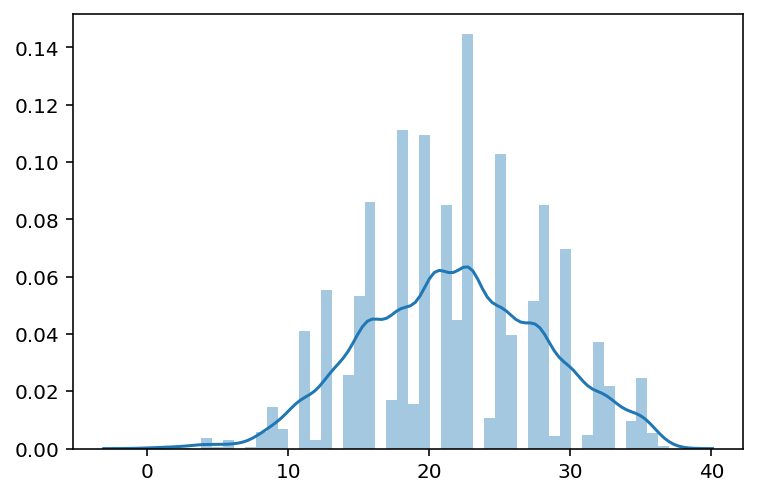

In [7]:
'''
data is highly unbalanced
# '''
sns.distplot(torch.tensor(network_output).cpu())
xx = pd.DataFrame(torch.tensor(network_output).cpu())
xx.groupby(0).size().to_frame(name='values')

In [8]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -117]
network_output = network_output[: -117]

print(network_input.shape)
print(network_output.shape)

torch.Size([8500, 50, 1])
torch.Size([8500])


In [9]:
#network_input[0]

In [15]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, hidden1, hidden2,batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden2
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(1, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(1, batch_size, self.hidden_size).zero_().cuda())
        
        hidden2 = (weight.new(1, batch_size, 38).zero_().cuda(),
          weight.new(1, batch_size, 38).zero_().cuda())
        return hidden1,hidden2

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [16]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [17]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [18]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [19]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [21]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden1, hidden2 = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        #h = tuple([each.data for each in hidden])
        
        h1 = tuple([each.data for each in hidden1])
        h2 = tuple([each.data for each in hidden2])
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, _ = model.forward(inputs, h1, h2, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h1 = tuple([each.data for each in hidden1])
        val_h2 = tuple([each.data for each in hidden2])
        
        output, _ = model.forward(inputs, val_h1, val_h2,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_different_layers_testing.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.0305562 	Val Loss:2.9375344 	Train Acc: 9.985294% 	Val Acc: 11.4117651%
Validation Loss decreased from    inf to 2.937534, saving the model weights
Epoch: 1	Train Loss: 3.0294230 	Val Loss:2.9288061 	Train Acc: 10.69118% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.937534 to 2.928806, saving the model weights
Epoch: 2	Train Loss: 3.0119009 	Val Loss:2.8572389 	Train Acc: 10.75% 	Val Acc: 13.0000003%
Validation Loss decreased from 2.928806 to 2.857239, saving the model weights
Epoch: 3	Train Loss: 2.9647393 	Val Loss:2.8269452 	Train Acc: 10.98529% 	Val Acc: 12.4117650%
Validation Loss decreased from 2.857239 to 2.826945, saving the model weights
Epoch: 4	Train Loss: 2.8721788 	Val Loss:2.7354527 	Train Acc: 12.47059% 	Val Acc: 12.9411768%
Validation Loss decreased from 2.826945 to 2.735453, saving the model weights
Epoch: 5	Train Loss: 2.8226022 	Val Loss:2.6582330 	Train Acc: 12.85294% 	Val Acc: 13.4117650%
Validation Loss decreased from 2.735453 to 2.

Epoch: 58	Train Loss: 2.3442806 	Val Loss:2.3192040 	Train Acc: 22.0% 	Val Acc: 18.1764710%
Epoch: 59	Train Loss: 2.3399081 	Val Loss:2.3143006 	Train Acc: 21.19118% 	Val Acc: 17.9411769%
Epoch: 60	Train Loss: 2.3416007 	Val Loss:2.2969794 	Train Acc: 20.98529% 	Val Acc: 19.8235299%
Validation Loss decreased from 2.297929 to 2.296979, saving the model weights
Epoch: 61	Train Loss: 2.3137733 	Val Loss:2.2814265 	Train Acc: 22.02941% 	Val Acc: 19.8235299%
Validation Loss decreased from 2.296979 to 2.281427, saving the model weights
Epoch: 62	Train Loss: 2.3186954 	Val Loss:2.2859871 	Train Acc: 22.41177% 	Val Acc: 20.7647064%
Epoch: 63	Train Loss: 2.3099184 	Val Loss:2.2843409 	Train Acc: 22.82353% 	Val Acc: 20.0000003%
Epoch: 64	Train Loss: 2.3079038 	Val Loss:2.2862053 	Train Acc: 22.83824% 	Val Acc: 20.8823535%
Epoch: 65	Train Loss: 2.3034010 	Val Loss:2.2697633 	Train Acc: 22.83824% 	Val Acc: 21.4705886%
Validation Loss decreased from 2.281427 to 2.269763, saving the model weights
Ep

Epoch: 121	Train Loss: 1.9441544 	Val Loss:1.8723162 	Train Acc: 35.44118% 	Val Acc: 38.4705889%
Validation Loss decreased from 1.890494 to 1.872316, saving the model weights
Epoch: 122	Train Loss: 1.9420622 	Val Loss:1.8696297 	Train Acc: 34.47059% 	Val Acc: 37.5882360%
Validation Loss decreased from 1.872316 to 1.869630, saving the model weights
Epoch: 123	Train Loss: 1.9517780 	Val Loss:1.8767270 	Train Acc: 34.57353% 	Val Acc: 37.6470596%
Epoch: 124	Train Loss: 1.9218104 	Val Loss:1.8707884 	Train Acc: 35.58824% 	Val Acc: 40.3529418%
Epoch: 125	Train Loss: 1.9301995 	Val Loss:1.7915739 	Train Acc: 35.02941% 	Val Acc: 41.1176476%
Validation Loss decreased from 1.869630 to 1.791574, saving the model weights
Epoch: 126	Train Loss: 1.8993551 	Val Loss:1.7970177 	Train Acc: 36.88235% 	Val Acc: 41.3529420%
Epoch: 127	Train Loss: 1.8861517 	Val Loss:1.7883075 	Train Acc: 36.86765% 	Val Acc: 41.5882361%
Validation Loss decreased from 1.791574 to 1.788307, saving the model weights
Epoch: 12

Epoch: 185	Train Loss: 1.2932688 	Val Loss:1.0886159 	Train Acc: 57.91177% 	Val Acc: 65.5882353%
Validation Loss decreased from 1.150665 to 1.088616, saving the model weights
Epoch: 186	Train Loss: 1.2827869 	Val Loss:1.0900188 	Train Acc: 57.92647% 	Val Acc: 65.2941179%
Epoch: 187	Train Loss: 1.3097592 	Val Loss:1.1367617 	Train Acc: 57.01471% 	Val Acc: 65.8235294%
Epoch: 188	Train Loss: 1.3441963 	Val Loss:1.0675265 	Train Acc: 55.89706% 	Val Acc: 66.1176473%
Validation Loss decreased from 1.088616 to 1.067527, saving the model weights
Epoch: 189	Train Loss: 1.3046138 	Val Loss:1.0420449 	Train Acc: 56.98529% 	Val Acc: 68.5882360%
Validation Loss decreased from 1.067527 to 1.042045, saving the model weights
Epoch: 190	Train Loss: 1.2720761 	Val Loss:1.0560046 	Train Acc: 58.57353% 	Val Acc: 68.0588245%
Epoch: 191	Train Loss: 1.2491718 	Val Loss:0.9551613 	Train Acc: 59.0% 	Val Acc: 71.8235296%
Validation Loss decreased from 1.042045 to 0.955161, saving the model weights
Epoch: 192	Tr

Epoch: 252	Train Loss: 0.7244441 	Val Loss:0.4134104 	Train Acc: 76.92647% 	Val Acc: 89.6470582%
Validation Loss decreased from 0.421827 to 0.413410, saving the model weights
Epoch: 253	Train Loss: 0.7241521 	Val Loss:0.4502451 	Train Acc: 76.98529% 	Val Acc: 87.5882339%
Epoch: 254	Train Loss: 0.7398014 	Val Loss:0.4582875 	Train Acc: 76.64706% 	Val Acc: 87.3529404%
Epoch: 255	Train Loss: 0.7390928 	Val Loss:0.4666015 	Train Acc: 76.47059% 	Val Acc: 87.2352934%
Epoch: 256	Train Loss: 0.7126986 	Val Loss:0.4396753 	Train Acc: 77.41176% 	Val Acc: 87.9411763%
Epoch: 257	Train Loss: 0.7189913 	Val Loss:0.3951257 	Train Acc: 76.86765% 	Val Acc: 89.5882344%
Validation Loss decreased from 0.413410 to 0.395126, saving the model weights
Epoch: 258	Train Loss: 0.7133607 	Val Loss:0.3922655 	Train Acc: 76.94118% 	Val Acc: 88.5882348%
Validation Loss decreased from 0.395126 to 0.392265, saving the model weights
Epoch: 259	Train Loss: 0.7228808 	Val Loss:0.4724909 	Train Acc: 77.36765% 	Val Acc: 86

Epoch: 320	Train Loss: 0.3651269 	Val Loss:0.1256826 	Train Acc: 88.80882% 	Val Acc: 96.9999993%
Validation Loss decreased from 0.126335 to 0.125683, saving the model weights
Epoch: 321	Train Loss: 0.3606538 	Val Loss:0.1167430 	Train Acc: 89.41176% 	Val Acc: 97.8823513%
Validation Loss decreased from 0.125683 to 0.116743, saving the model weights
Epoch: 322	Train Loss: 0.3690703 	Val Loss:0.1138524 	Train Acc: 88.25% 	Val Acc: 97.7058804%
Validation Loss decreased from 0.116743 to 0.113852, saving the model weights
Epoch: 323	Train Loss: 0.3518079 	Val Loss:0.0918861 	Train Acc: 88.91176% 	Val Acc: 98.3529401%
Validation Loss decreased from 0.113852 to 0.091886, saving the model weights
Epoch: 324	Train Loss: 0.3504415 	Val Loss:0.1051986 	Train Acc: 88.67647% 	Val Acc: 97.6470584%
Epoch: 325	Train Loss: 0.3402987 	Val Loss:0.1140292 	Train Acc: 89.25% 	Val Acc: 97.8823519%
Epoch: 326	Train Loss: 0.3529135 	Val Loss:0.1146619 	Train Acc: 88.64706% 	Val Acc: 97.6470572%
Epoch: 327	Trai

Epoch: 392	Train Loss: 0.1577290 	Val Loss:0.0314668 	Train Acc: 95.20588% 	Val Acc: 99.2352933%
Epoch: 393	Train Loss: 0.1645756 	Val Loss:0.0320018 	Train Acc: 95.19118% 	Val Acc: 99.2352927%
Epoch: 394	Train Loss: 0.1796114 	Val Loss:0.0354582 	Train Acc: 94.42647% 	Val Acc: 99.1764700%
Epoch: 395	Train Loss: 0.1772296 	Val Loss:0.0325412 	Train Acc: 94.79412% 	Val Acc: 99.2941165%
Epoch: 396	Train Loss: 0.1851037 	Val Loss:0.0303015 	Train Acc: 94.61765% 	Val Acc: 99.4117641%
Epoch: 397	Train Loss: 0.1886626 	Val Loss:0.0326893 	Train Acc: 94.54412% 	Val Acc: 99.2941165%
Epoch: 398	Train Loss: 0.1781358 	Val Loss:0.0344161 	Train Acc: 94.66176% 	Val Acc: 99.0588230%
Epoch: 399	Train Loss: 0.1976542 	Val Loss:0.0622033 	Train Acc: 94.07353% 	Val Acc: 98.4117633%
Epoch: 400	Train Loss: 0.2309575 	Val Loss:0.0559805 	Train Acc: 92.95588% 	Val Acc: 98.5294116%
Epoch: 401	Train Loss: 0.2300948 	Val Loss:0.0583752 	Train Acc: 92.89706% 	Val Acc: 98.2941163%
Epoch: 402	Train Loss: 0.24859

Epoch: 471	Train Loss: 0.1319607 	Val Loss:0.0194185 	Train Acc: 96.2647% 	Val Acc: 99.3529397%
Epoch: 472	Train Loss: 0.1217306 	Val Loss:0.0171505 	Train Acc: 96.25% 	Val Acc: 99.2941171%
Epoch: 473	Train Loss: 0.1223118 	Val Loss:0.0193340 	Train Acc: 96.47059% 	Val Acc: 99.4117635%
Epoch: 474	Train Loss: 0.1244027 	Val Loss:0.0200151 	Train Acc: 96.61765% 	Val Acc: 99.2352927%
Epoch: 475	Train Loss: 0.1417365 	Val Loss:0.0189887 	Train Acc: 96.02941% 	Val Acc: 99.4117630%
Epoch: 476	Train Loss: 0.1385792 	Val Loss:0.0208220 	Train Acc: 95.95588% 	Val Acc: 99.5294100%
Epoch: 477	Train Loss: 0.1368734 	Val Loss:0.0282534 	Train Acc: 96.05882% 	Val Acc: 99.1176462%
Epoch: 478	Train Loss: 0.1355772 	Val Loss:0.0436632 	Train Acc: 96.04412% 	Val Acc: 99.1176456%
Epoch: 479	Train Loss: 0.1411443 	Val Loss:0.0337354 	Train Acc: 95.75% 	Val Acc: 98.9999992%
Epoch: 480	Train Loss: 0.1601478 	Val Loss:0.0703281 	Train Acc: 94.86765% 	Val Acc: 98.1176454%
Epoch: 481	Train Loss: 0.2256745 	Val

## MUSIC GENERATION

In [50]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_different_layers_testing.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [65]:
#load population database
testing_data = np.ones(200)*0
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

In [66]:
#testing_data

In [67]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    h1, h2 = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        test_hidden1 = tuple([each.data for each in h1])
        test_hidden2 = tuple([each.data for each in h2])
        
        test_output,_ = test_model.forward(test_slice, test_hidden1, test_hidden2, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [68]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [69]:
#predicted_notes_lst

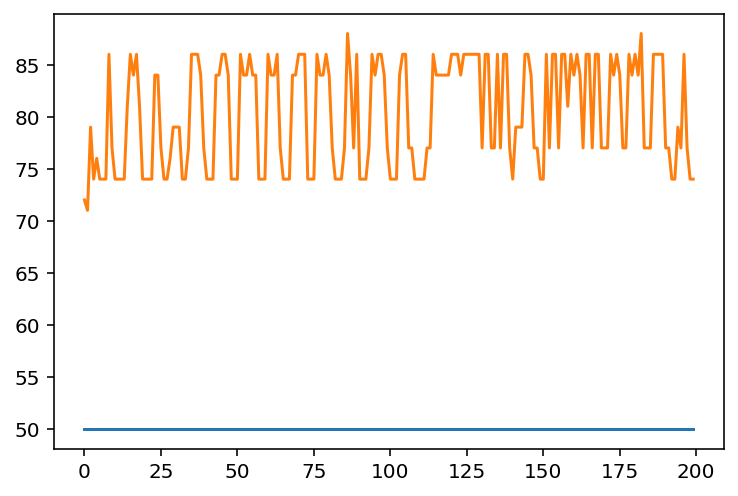

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))
plt.plot(list(np.ones(200)*50))
#plt.plot(testing_data)
plt.plot(predicted_notes_lst)

In [64]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({86: 10, 83: 13, 79: 1, 84: 11, 81: 4, 85: 161})